# Spark Clustering

This is question number 3.

we are creating a cluster based on 150 hotels with top 40 check-ins by discount code.

Here we initialize spark

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

spark = SparkSession.builder.master('local').appName('hotels').getOrCreate()
            
sc = spark.sparkContext 

 # Top 150 hotels
 Counted by apperance in the data file.

In [3]:
def ByHotelName(row):
    key = row['Hotel Name']
    val = 1
    return (key,val)

def countReduce(val1, val2):
    return (val1 + val2)

hotels_num = 150

hotels_rdd = spark.read.csv('./Hotels_data_Changed.csv',header=True).rdd
hotel_names_top150 = hotels_rdd \
            .map(ByHotelName) \
            .reduceByKey(countReduce) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(hotels_num)
            
hotel_names_keys = sc.parallelize(hotel_names_top150).keys().collect()
            
hotels_top = hotels_rdd.filter(lambda x: x['Hotel Name'] in hotel_names_keys)

for index,hotel in enumerate(hotel_names_top150):
    print (index+1, hotel[0],hotel[1])

1 Newark Liberty International Airport Marriott 5346
2 Hilton Garden Inn Times Square 4892
3 Residence Inn Newark Elizabeth Liberty International Airport 4314
4 Westin New York at Times Square 3792
5 Loews Regency New York Hotel 3617
6 Viceroy New York 3565
7 Four Seasons Hotel New York 3243
8 Langham Place New York Fifth Avenue 3203
9 The Carlyle A Rosewood Hotel 3078
10 DoubleTree by Hilton Metropolitan - New York City 2866
11 Magnuson Convention Center Hotel 2862
12 Hilton Garden Inn New York West 35th Street 2822
13 Hilton Garden Inn New York-Times Square Central 2772
14 Conrad New York 2677
15 Wyndham Garden Brooklyn Sunset Park 2599
16 Hilton Newark Airport 2524
17 Omni Berkshire Place 2358
18 Hilton Times Square 2273
19 Park Hyatt New York 2226
20 Homewood Suites by Hilton NY Midtown Manhattan Times Square 2211
21 Grand Hyatt New York 2165
22 The Plaza Hotel 2149
23 Quality Inn Woodside 2140
24 Hyatt Union Square New York 2114
25 Le Parker Meridien New York 2109
26 The New York 

# Top 40 check-ins hotels
 

In [4]:
def ByCheckinDate(row):
    key = row['Checkin Date']
    val = 1
    return (key,val)

checkin_date_num = 40

checkin_top = hotels_top \
            .map(ByCheckinDate) \
            .reduceByKey(countReduce) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(checkin_date_num)

checkin_top_keys = sc.parallelize(checkin_top).keys().collect()
checkin_top_keys.sort()
            
top_hotels_in_date = hotels_top.filter(lambda x: x['Checkin Date'] in checkin_top_keys) \
                        .sortBy(lambda x: x['Discount Code']) \
                        .sortBy(lambda x: x['Hotel Name']) \
                        .sortBy(lambda x: x['Checkin Date'])

for index,date in enumerate(checkin_top):
    print(index+1,date[0],date[1])

1 2015-11-11 2302
2 2015-10-14 1887
3 2015-11-04 1885
4 2015-08-19 1883
5 2015-10-28 1861
6 2015-10-21 1817
7 2015-11-06 1808
8 2015-08-12 1765
9 2015-11-05 1684
10 2015-10-22 1662
11 2015-11-12 1649
12 2015-09-10 1623
13 2015-10-29 1623
14 2015-09-09 1616
15 2015-11-18 1582
16 2015-08-26 1559
17 2015-11-10 1548
18 2015-11-13 1547
19 2015-10-15 1473
20 2015-11-21 1469
21 2015-09-30 1464
22 2015-10-30 1412
23 2015-09-16 1407
24 2015-09-17 1402
25 2015-11-28 1383
26 2015-10-01 1373
27 2015-11-26 1356
28 2015-09-11 1332
29 2015-09-18 1326
30 2015-10-16 1309
31 2015-11-27 1306
32 2015-10-02 1280
33 2015-10-07 1257
34 2015-11-07 1256
35 2015-08-28 1251
36 2015-08-27 1239
37 2015-10-27 1227
38 2015-11-03 1215
39 2015-08-13 1210
40 2015-11-25 1175


## ***Cluster pre-process ***

Create a matrix that represents all of the hotels-prices-codes combinations.


(Including setting -1 for future missing data, since some hotels might have no data on some check-in dates)

In [5]:
def createAllKeys(hotels,dates,codes):
    names_keys = sc.parallelize(hotels)
    dates_keys = sc.parallelize(dates)
    codes_keys = sc.parallelize(codes)
    return names_keys.cartesian(dates_keys.cartesian(codes_keys)).map(lambda x: (x[0], x[1][0], x[1][1]))

hotels_date_price_missing_data = createAllKeys(hotel_names_keys,checkin_top_keys,['1','2','3','4']).map(lambda x: (x, -1))

## *** Structure the data ***

Manipulating the original csv file so we can use it later, for merging the data.



In [6]:
def HotelDatesDiscountCodeMapFunc(row):
    key = (row['Hotel Name'],row['Checkin Date'],row['Discount Code'])
    val = float(row['Discount Price'])
    return (key,val)


hotels_date_price = top_hotels_in_date.map(HotelDatesDiscountCodeMapFunc)

## *** Data merge ***

Scanning the original and manipulated file, to create a "image" that includes the minimal price for each key
Creating groups based on the hotel names,so we can use it while clustering the data.


In [8]:
def ByHotelAndCheckinDateReduceFunc(val1,val2):
    if val1 == -1:
        return val2
    elif val2 == -1:
        return val1
    else:
        return min(val1,val2)
    
hotels_date_price_all_values_before_group = sc.union([hotels_date_price_missing_data, hotels_date_price]).reduceByKey(ByHotelAndCheckinDateReduceFunc).sortByKey()
hotels_date_price_all_values = hotels_date_price_all_values_before_group.map(lambda x: (x[0][0], x[1])).groupByKey().sortByKey().mapValues(list)

### *** Prices of hotels in check-in dates for each discount code ***

In [9]:
import pandas as pd

columns = ['Hotel Name'] + [i for i in hotels_date_price_all_values_before_group.map(lambda x: (x[0][1], x[0][2])).distinct().sortBy(lambda x: x[1]).sortByKey().collect()]

pd.set_option('max_colwidth',200)
df = pd.DataFrame(hotels_date_price_all_values.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,Andaz 5th Avenue - a concept by Hyatt,-1.0,-1.0,1665.0,-1.0,-1.0,-1.0,-1.0,1339.0,-1.0,...,2181.0,-1.0,-1.0,2778.0,2077.0,2462.0,2884.0,2161.0,2604.0,2944.0
2,Andaz Wall Street - a concept by Hyatt,1365.0,1325.0,1355.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1138.0,1098.0,2066.0,1484.0,1371.0,1785.0,1749.0,1578.0,-1.0,-1.0
3,Baccarat Hotel and Residences New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,5225.0,5225.0,4250.0,-1.0,-1.0,-1.0,-1.0
4,Bentley Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1104.0,-1.0
5,Best Western Bayside Inn,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,796.0,-1.0,677.0,736.0,786.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,Best Western Bowery Hanbee Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1026.0,985.0
7,Best Western Plus Arena Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1006.0,-1.0,-1.0,872.0,677.0,-1.0,-1.0
8,Best Western Plus Newark Airport West,620.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,538.0,556.0,-1.0,-1.0,-1.0,553.0,-1.0,-1.0
9,Blakely New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## *** Normalisation ***

Using a standart MinMax normalisation (price of -1 will stay -1 - missing data, when there is no diff return 0)



In [10]:
def normalise(prices):
    filtered_prices = list(filter(lambda x: x != -1, prices))
    
    if len(filtered_prices) == 0:
        return prices
    
    max_price = max(filtered_prices)
    min_price = min(filtered_prices)
    
    diff = max_price - min_price
    
    normalized_prices = []
    for price in prices:
        if price == -1:
            normalized_prices.append(price)
        elif diff == 0:
            normalized_prices.append(diff)
        else:
            normalized_prices.append(float(price - min_price) * 100/diff)
            
    return normalized_prices

normalised_hotels_prices = hotels_date_price_all_values.map(lambda x: (x[0], normalise(x[1])))
normalised_prices = normalised_hotels_prices.values()

df = pd.DataFrame(normalised_hotels_prices.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,-1.000000,-1.000000,20.311526,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,52.461059,-1.000000,-1.000000,89.657321,45.981308,69.968847,96.261682,51.214953,78.816199,100.000000
2,Andaz Wall Street - a concept by Hyatt,22.478386,20.172911,21.902017,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,9.394813,7.089337,62.881844,29.337176,22.824207,46.685879,44.610951,34.755043,-1.000000,-1.000000
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,85.714286,85.714286,35.064935,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,11.147851,-1.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,70.484581,-1.000000,18.061674,44.052863,66.079295,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,20.685279,15.482234
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,49.924127,-1.000000,-1.000000,29.590288,0.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,60.377358,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,8.805031,20.125786,-1.000000,-1.000000,-1.000000,18.238994,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


## *** Hierarchy cluster ***

Training the hierarchy cluster based on the normalised data

The algorithm finds the hotels cluster based on the prices trends smillarity.
we will compare a few methods.


In [11]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from matplotlib import pyplot as plt

normalised_prices_data = normalised_prices.take(hotels_num)

ward = linkage(normalised_prices_data, 'ward')
wardc, coph_dists = cophenet(ward, pdist(normalised_prices_data))
complete = linkage(normalised_prices_data, 'complete')
completec, coph_dists = cophenet(complete, pdist(normalised_prices_data))
single = linkage(normalised_prices_data, 'single')
singlec, coph_dists = cophenet(single, pdist(normalised_prices_data))
average = linkage(normalised_prices_data, 'average')
averagec, coph_dists = cophenet(average, pdist(normalised_prices_data))
weighted = linkage(normalised_prices_data, 'weighted')
weightedc, coph_dists = cophenet(weighted, pdist(normalised_prices_data))

print('Ward:' + str(wardc))
print('Complete:' + str(completec))
print('Single:' + str(singlec))
print('Average:' + str(averagec))
print('Weighted:' + str(weightedc))

Ward:0.6313690597146779
Complete:0.798077808945792
Single:0.8386306685599263
Average:0.883316795409844
Weighted:0.8085457332927564


The average distance method gives us the best result (The more closer to 1 - the better).

Create a dendrogram of the "average" method linkage:

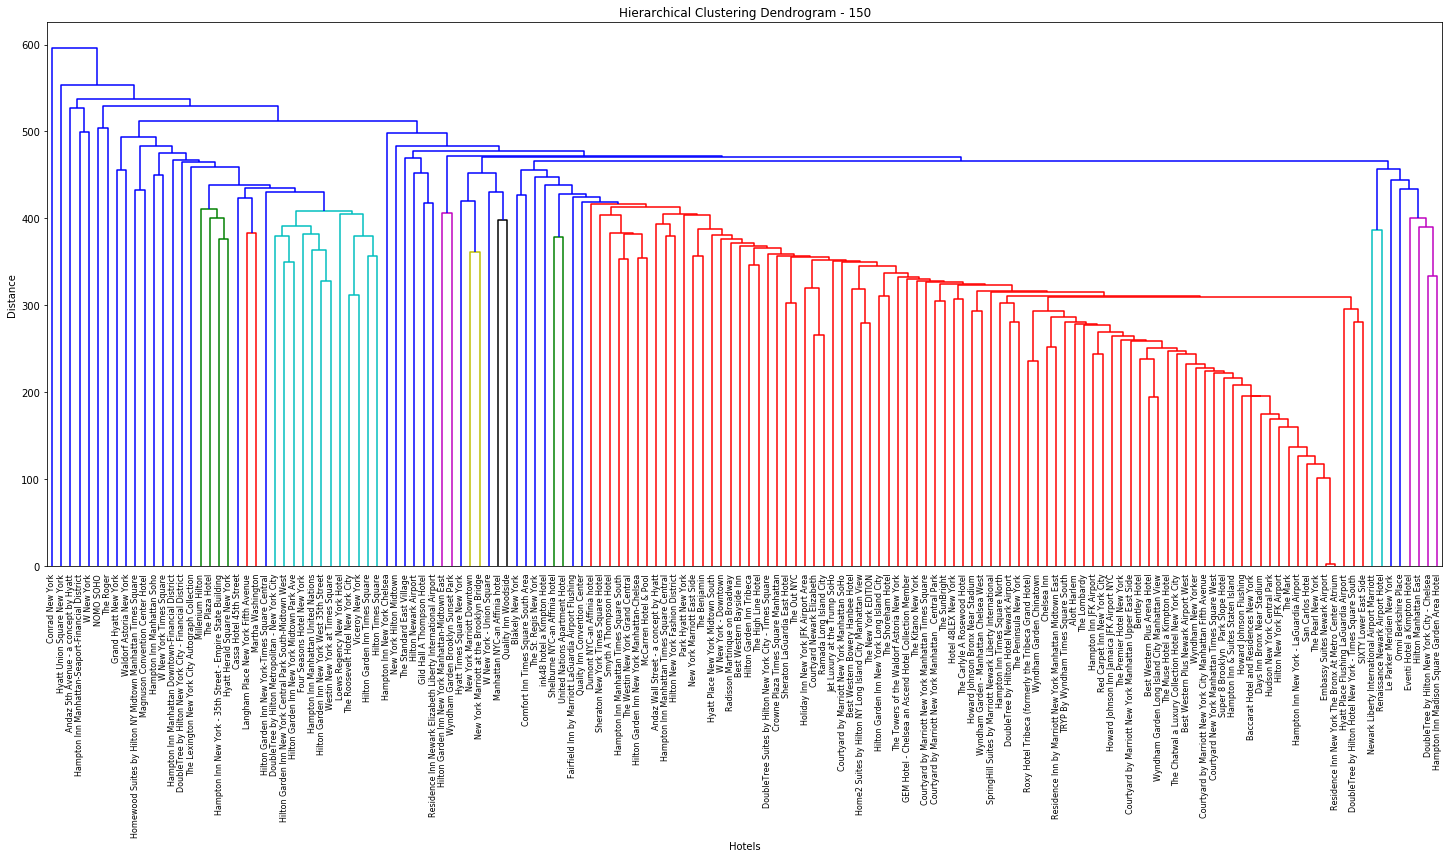

In [12]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - {}'.format(hotels_num))
plt.xlabel('Hotels')
plt.ylabel('Distance')

dendrogram(average,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=hotels_num,
    show_contracted=True,  # to get a distribution impression in truncated branches
    labels=normalised_hotels_prices.map(lambda x: x[0]).sortBy(lambda x: x).take(hotels_num)
)

plt.show()

### *** Explaining the Dendrogram ***

Each cluster has its own color.Therefore, for example, All of the hotels in the blue cluster have similar prices for the same dates.
